**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Constant Source, and Robin BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**21 Oct 2024**

---
## Table of Contents<a id="toc"></a>
* [Problem Conditions](#whatisit)
* [Setup](#setup)
* [Test Two](#test)
---

## [Problem conditions](#toc)<a id='whatisit'></a>

A constant thermal conductivity with a constant source are used with temperature enforced on both ends of the domain. Namely,

 + $k(x) = 87219 \left [ \frac{W}{mK} \right ]$
 + $f(x)= 209386\; \left [ \frac{W}{m^{3}} \right ]$
 + $T(a)=20$ [°C], and $T(b)=40$ [°C]

respectively.

## [Setup](#toc)<a id="setup"></a>

In [45]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min=0
x_max=0.05

degree = 2  #Degree of the lagrange polinomials used
n_elem = 10 #Number of elements used

In [46]:
'''Domain partition'''
from pyfires import get_domain_partition

In [47]:
'''Parent mapping'''
from pyfires import get_parent_mapping

In [48]:
'''Local basis functions'''
from pyfires import get_parent_basis_functions

In [49]:
'''Global basis functions'''
from pyfires import global_basis_function

In [50]:
'''All global basis functions'''
from pyfires import get_global_basis_functions

In [51]:
'''Pedagogical inner product'''
from pyfires import inner_product

In [52]:
'''FEM Solution'''
'''Domain partition'''
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='flux', bc_x_max='flux')
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

## [Implementing Constraints](#toc)<a id="test"></a>

Test two constraints the system with a constant thermal conductivity and a constant heat source using a Robin boundary condition. The goal of simulating the domain with these conditions is to produce a graphical solution on how heat is transfered throughout the domain. 

In [53]:
'''Parameters'''
htc = 10      #Heat transfer coefficient

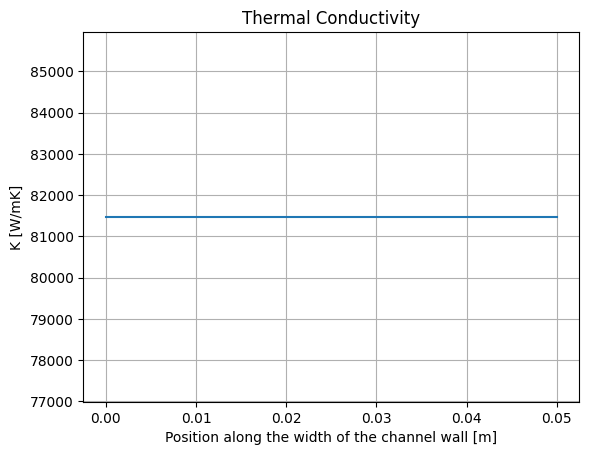

In [54]:
'''Thermal conductivity'''
from pyfires import linear_func
from pyfires import plot_func

k_func = linear_func(x_min, x_max, (156.0, 156.0)) # W/mK

'''Heating Power Density'''
f_func = linear_func(x_min, x_max, (206151.0, 212621.0)) # W/m^3

f_func = linear_func(x_min, x_max, (206.0, 206.0)) # W/m^3

view_plots = False

In [ ]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(k_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(f_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

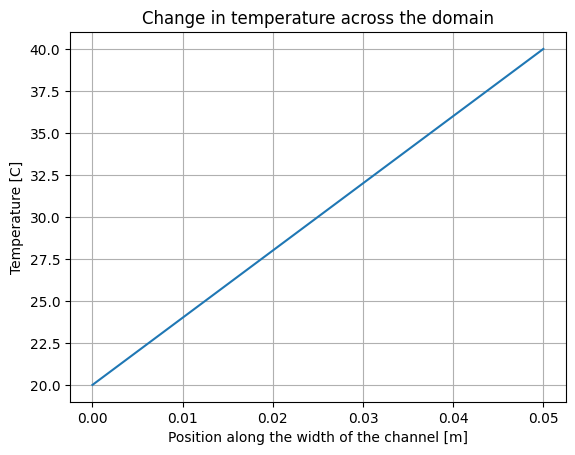

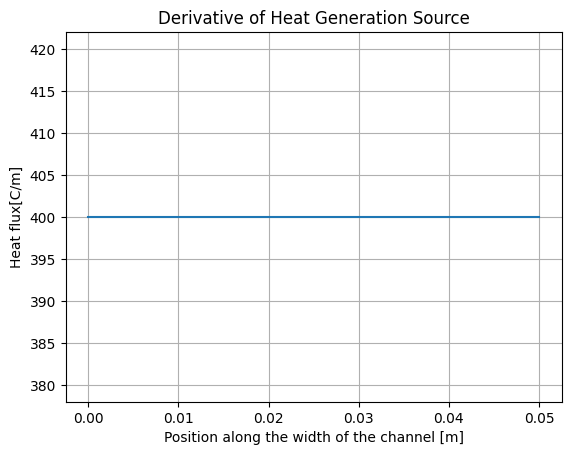

In [56]:
'''Building the lift function'''
u_a = 20 #temperature at point a in degrees C
u_b = 40 #temperature at point b in degrees C

lift_func = linear_func(x_min, x_max, (u_a, u_b)) # C
lift_prime = (u_b-u_a)/(x_max-x_min)
lift_func_prime = linear_func(x_min, x_max, (lift_prime, lift_prime)) # C

view_plots = False

In [ ]:
if view_plots:
    n_plot_pts = 200
    title = 'Lift Function'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'T [C]'
    plot_func(lift_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Lift Function Prime'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'dT/dx [C/m]'
    plot_func(lift_func_prime, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [57]:
'''Build FEM A Matrix'''
from pyfires import build_a_mtrx
a_mtrx = build_a_mtrx(phi_list, phi_prime_list, k_func, domain_partition, x_min, x_max, n_elem)

# A_mtrx[i,j] = inner_product(prima, d_x_phi_prime_j, patches) + h*phi_i(x_min)*phi_j(x_min) + h*phi_i(x_max)*phi_j(x_max)

In [60]:
'''Build load vector'''
#The load vector
b_vec = np.zeros(len(phi_list), dtype=np.float64)
patches = domain_partition[0]

for i in range(len(phi_list)):
    phi_i=phi_list[i]
    phi_prime_i=phi_prime_list[i]
    
    #b_vec[i] = inner_product(func_x, phi_i, patches)-htc*(temp_func(x_max)-u_b)*phi_i(x_max)-htc*(temp_func(x_min)-u_a)*phi_i(x_min)
    b_vec[i] = inner_product(func_x, phi_i, patches)-htc*(lift_func(x_max)-u_b)*phi_i(x_max)[0]-htc*(temp_func(x_min)-u_a)*phi_i(x_min)[0]
    
    first_term = lambda x: slope_func(x)*k_cond(x)
    phi_prima_i = lambda x: phi_prime_i(x)*(2/h_e)
    
    b_vec[i] -= inner_product(first_term, phi_prima_i, patches)

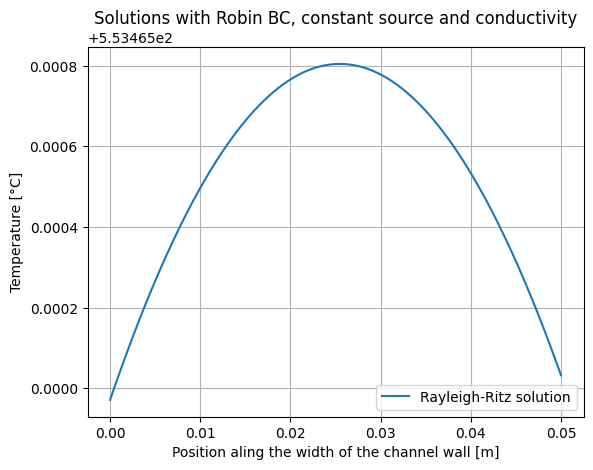

The value of the function at the leftmost end of the domain is: 553.46 [°C].
The value of the function at the rightmost end of the domain is: 553.47 [°C].


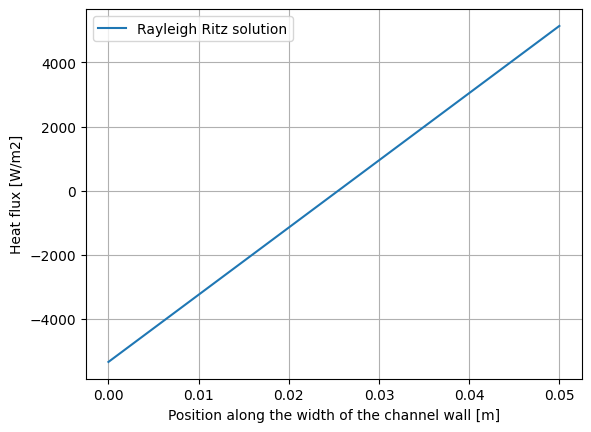

Flux at the boundaries:
q_na computed =  [-5334.64970617]
q_nb computed =  [5134.6503248]
flux error [%]=  [12736.625812]


In [67]:
'''Solution'''
'''Compute optimal coefficient vector'''
c_star_vec = np.linalg.solve(A_mtrx, b_vec)

'''Plot comparison of f and g_best_vec'''
from pyfires import u_star()
from pyfires import u_star_prime()

'''
def u_star(x):
    g_x=temp_func(x)
    for (j,phi_i) in enumerate(phi_list):
        g_x=g_x+(c_star_vec[j])*phi_i(x)
    return g_x
    
def u_star_prime(x):
    g_x=slope_func(x)
    for j in range(len(phi_list)):
        g_x=g_x+(c_star_vec[j])*((2/h_e)*phi_prime_list[j](x))
    return g_x
'''

#Plotting the solutions 
plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),u_star(np.linspace(x_min,x_max,2000)),label='Rayleigh-Ritz solution')
plt.title('Solutions with Robin BC, constant source and conductivity')
plt.xlabel("Position aling the width of the channel wall [m]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid()
plt.show()

#print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min))
print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min)[0])
#print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max))
print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max)[0])

#Plotting the flux
plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),-k_cond(np.linspace(x_min,x_max,2000))*u_star_prime((np.linspace(x_min,x_max,2000))),label='Rayleigh Ritz solution')
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("Heat flux [W/m2]")
plt.legend()
plt.grid()
plt.show()

#Flux at the boundaries 
print("Flux at the boundaries:") 
print('q_na computed = ', -k_cond(x_min)*u_star_prime(x_min))
print('q_nb computed = ', -k_cond(x_max)*u_star_prime(x_max))
print('flux error [%]= ',(-k_cond(x_max)*u_star_prime(x_max) - u_b)/u_b*100)